In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 210ms/step - loss: 0.2863 - root_mean_squared_error: 0.5350 - val_loss: 0.1319 - val_root_mean_squared_error: 0.3632
Epoch 2/50
53/53 [==============================] - 9s 175ms/step - loss: 0.1301 - root_mean_squared_error: 0.3607 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1576
Epoch 3/50
53/53 [==============================] - 9s 175ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 4/50
53/53 [==============================] - 8s 146ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1437
Epoch 5/50
53/53 [==============================] - 9s 174ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373
Epoch 6/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - val_loss: 0.0184 - va

Epoch 30/50
53/53 [==============================] - 14s 263ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 31/50
53/53 [==============================] - 2s 37ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 32/50
53/53 [==============================] - 13s 246ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 33/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 34/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 35/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0140 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.870877273877462 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

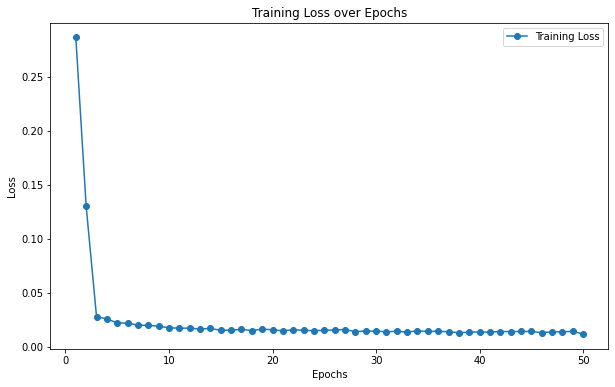

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

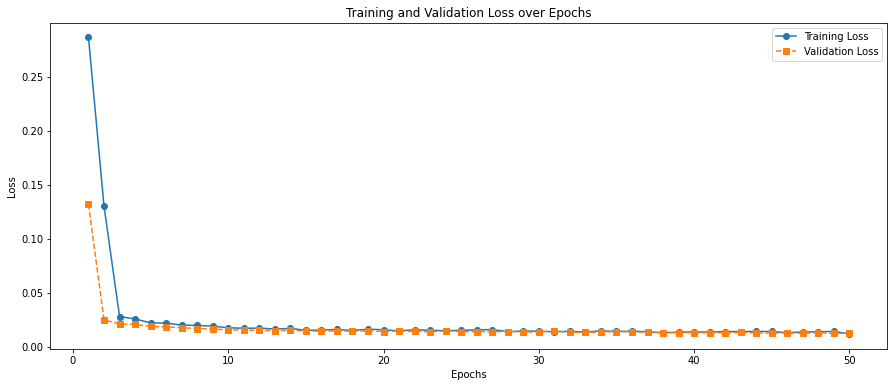

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09878113107595424
MAE : 0.07925010611713927


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,341209.40625,436530.907
1,311321.34375,283162.646
2,308612.71875,212475.431
3,339452.43750,386546.857
4,403849.56250,547183.986
5,487739.87500,584596.262
6,554420.56250,584830.109
7,608443.93750,641562.292
8,636943.00000,734946.437
9,636502.62500,777596.225


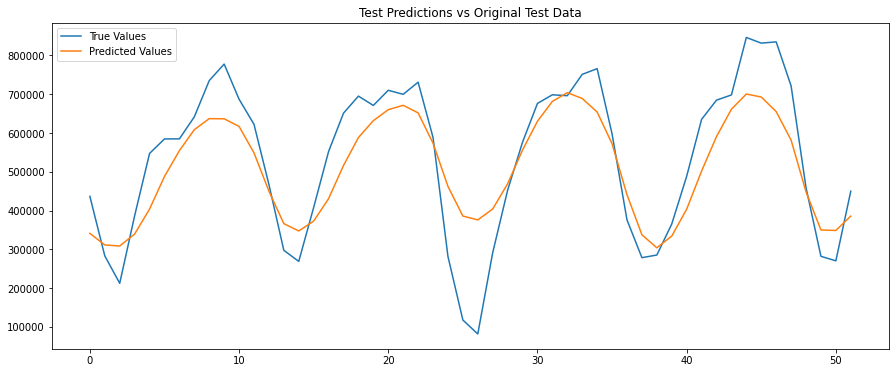

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 19ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

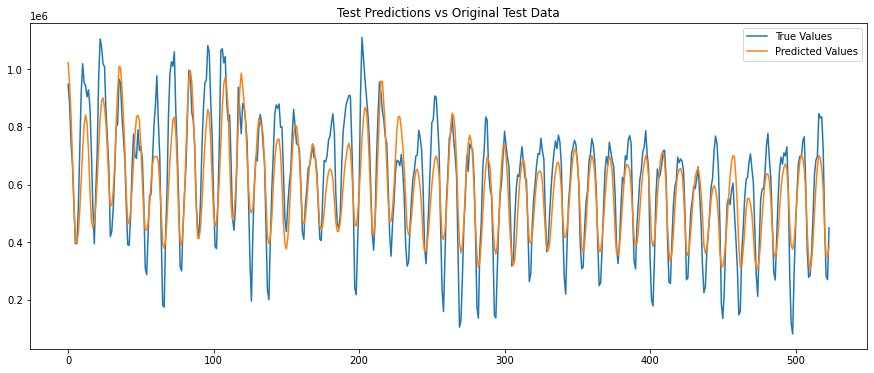

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()